# Import Modules

In [119]:
# import modules
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate
from lightgbm import LGBMRegressor
from functools import partial
import optuna

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 18

# Data Set

In [9]:
# read train, test, and submission files
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [10]:
# read files for train data
dipole = pd.read_csv('../data/dipole_moments.csv')
magnetic = pd.read_csv('../data/magnetic_shielding_tensors.csv')
mulliken = pd.read_csv('../data/mulliken_charges.csv')
potential = pd.read_csv('../data/potential_energy.csv')

In [ ]:
# read file for train and test data
structures = pd.read_csv('../data/structures.csv')

In [37]:
train.head(1)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076


In [22]:
dipole.head(1)

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0,0.0,0.0


In [29]:
magnetic.head(1)

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.315,0.0,-0.0001,0.0,195.317,0.0007,-0.0001,0.0007,195.317


In [28]:
mulliken.head(1)

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689


In [25]:
potential.head(1)

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368


In [61]:
structures.head(1)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001


# Data Explanation

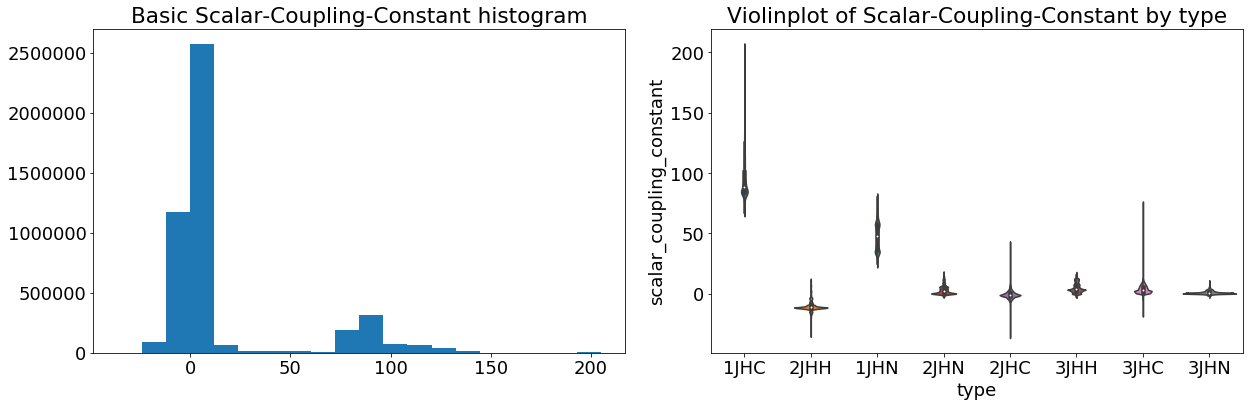

In [51]:
# scalar-coupling-constant histogram and violinplot of scalar-coupling-constant by type
fig, ax = plt.subplots(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(train['scalar_coupling_constant'], bins=20)
plt.title('Basic scalar-coupling-constant histogram')
plt.subplot(1, 2, 2)
sns.violinplot(x='type', y='scalar_coupling_constant', data=train)
plt.title('Violinplot of scalar-coupling-constant by type')
plt.tight_layout()
plt.show()

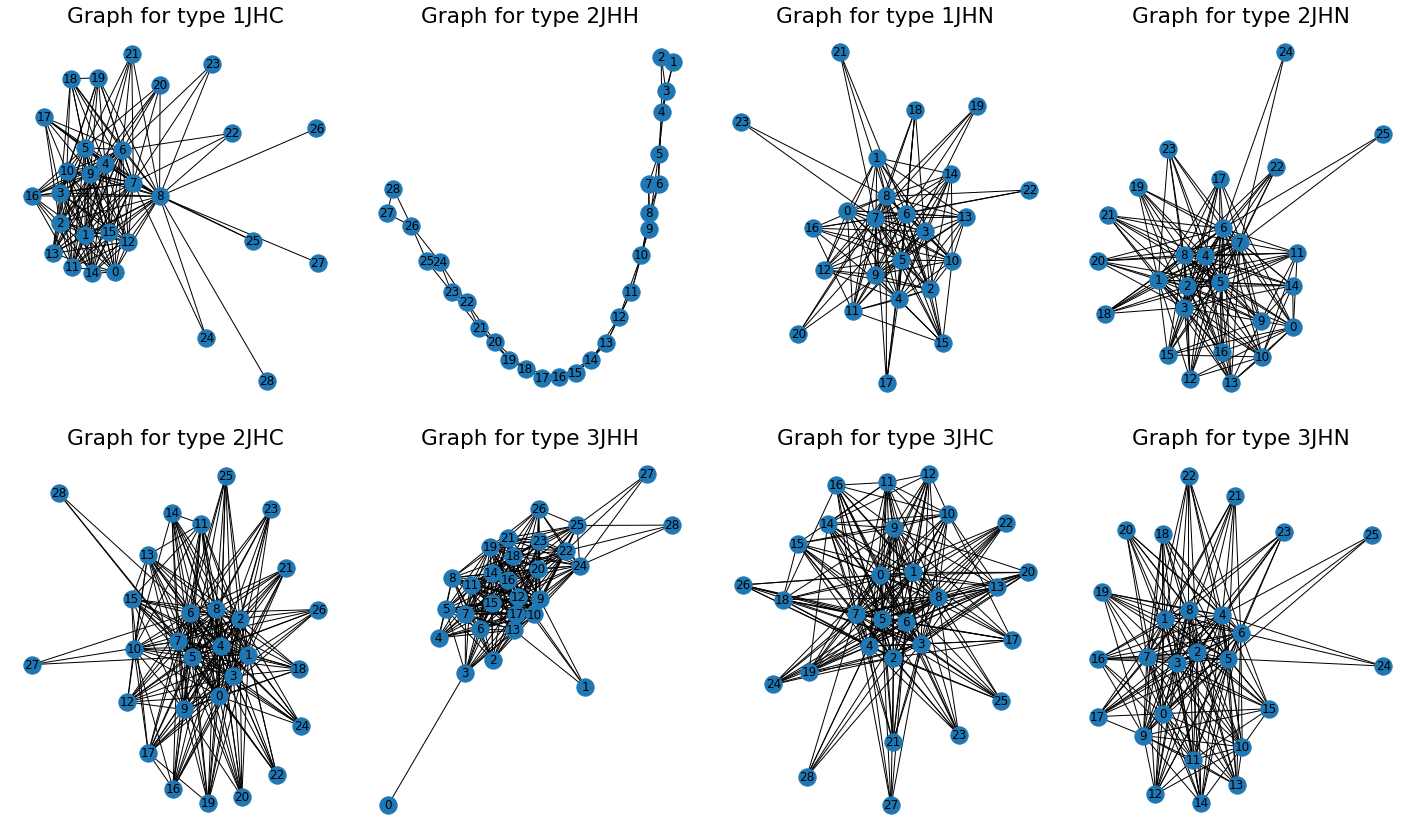

In [49]:
# network graphs by type
fig, ax = plt.subplots(figsize=(20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train[train['type']==t]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i+1)
    nx.draw(G, with_labels=True)
    plt.title(f'Graph for type {t}')
plt.tight_layout()
plt.show()

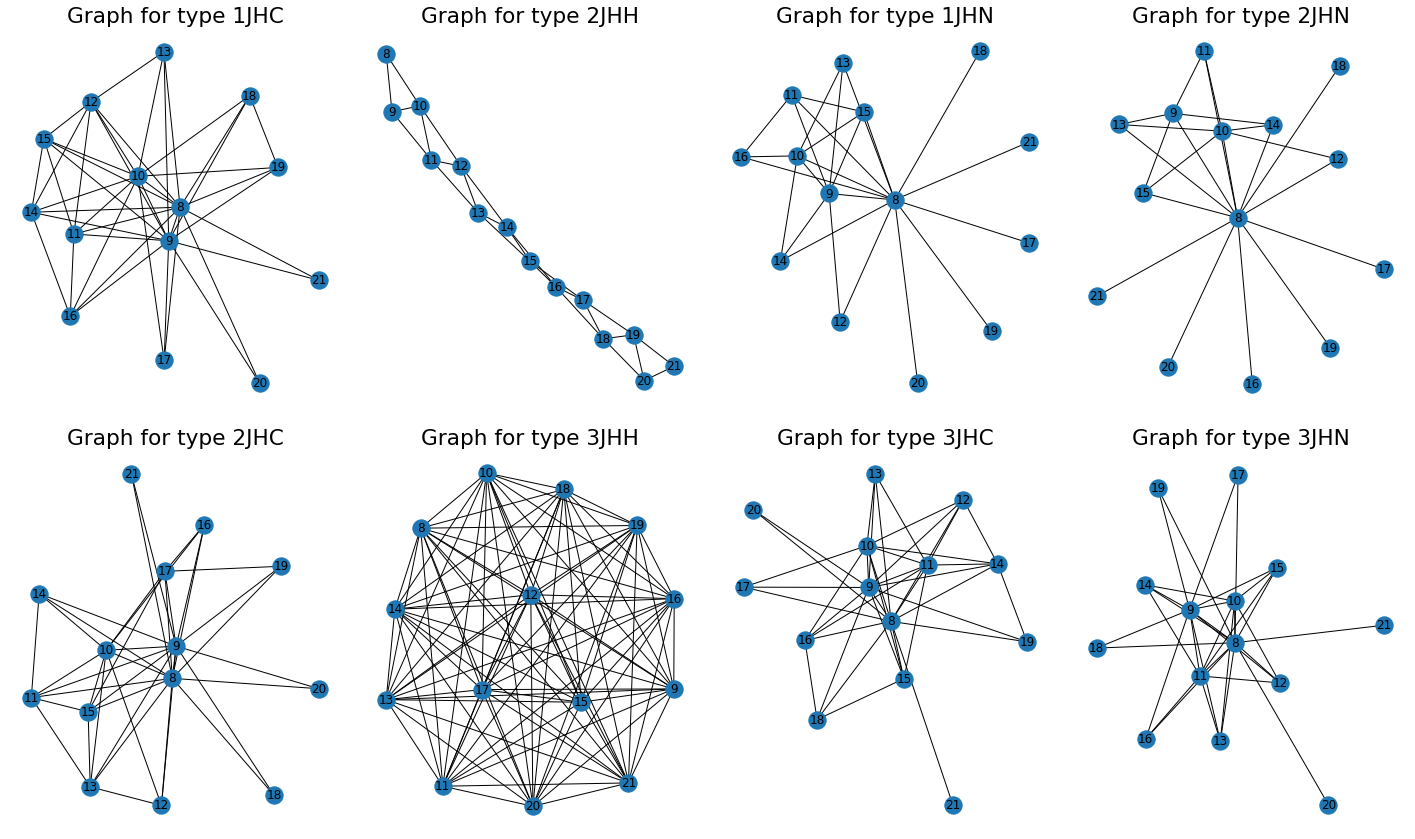

In [60]:
# better network graphs by type
fig, ax = plt.subplots(figsize=(20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train[train['type']==t]
    train_atoms_0 = train['atom_index_0'].value_counts(normalize=True)
    train_atoms_1 = train['atom_index_0'].value_counts(normalize=True)
    bad_atoms_0 = list(train_atoms_0[train_atoms_0<0.01].index)
    bad_atoms_1 = list(train_atoms_1[train_atoms_1<0.01].index)
    train_type = train_type[(~train_type['atom_index_0'].isin(bad_atoms_0))
                            &(~train_type['atom_index_1'].isin(bad_atoms_1))]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i+1)
    nx.draw(G, with_labels=True)
    plt.title(f'Graph for type {t}')
plt.tight_layout()
plt.show()

# Feature Engineering

In [62]:
# map information of atoms
def map_atom_info(df, index):
    df = pd.merge(df, structures, how='left',
                  left_on=['molecule_name', f'atom_index_{index}'],
                  right_on=['molecule_name', 'atom_index'])
    df = df.drop(columns='atom_index')
    df = df.rename(columns={'atom': f'atom_{index}',
                            'x': f'x_{index}',
                            'y': f'y_{index}',
                            'z': f'z_{index}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [63]:
# add distance between two atoms
def add_distance(df):
    p_0 = df[['x_0', 'y_0', 'z_0']].values
    p_1 = df[['x_1', 'y_1', 'z_1']].values
    df['dist'] = np.linalg.norm(p_0-p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    return df

train = add_distance(train)
test = add_distance(test)

In [65]:
# devide type into number and charactor
def devide_type(df):
    df['type_0'] = df['type'].apply(lambda x: x[0])
    df['type_1'] = df['type'].apply(lambda x: x[1:])
    return df

train = devide_type(train)
test = devide_type(test)

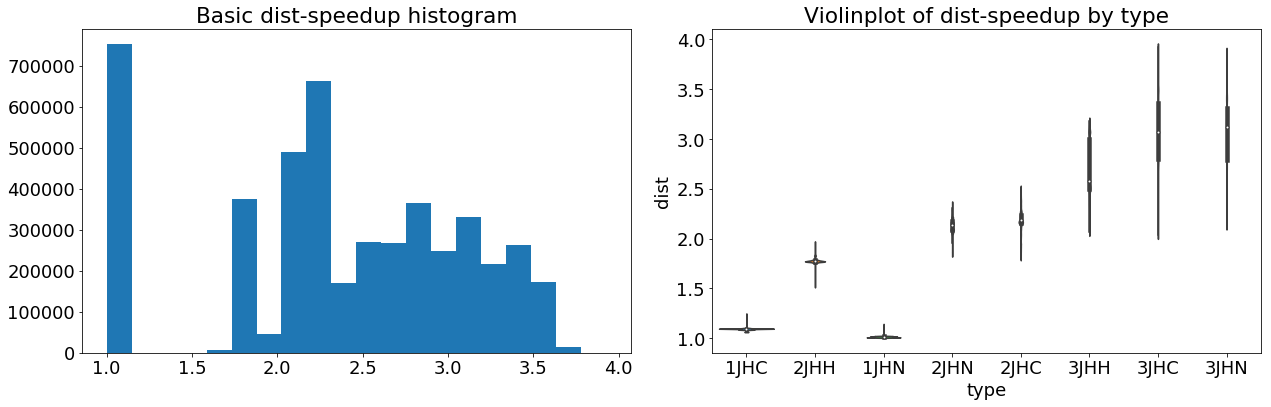

In [70]:
# dist-speedup histogram and violinplot of dist-speedup by type
fig, ax = plt.subplots(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(train['dist'], bins=20)
plt.title('Basic dist-speedup histogram')
plt.subplot(1, 2, 2)
sns.violinplot(x='type', y='dist', data=train)
plt.title('Violinplot of dist-speedup by type')
plt.tight_layout()
plt.show()

In [80]:
# normalize distance by type
def distance_normalization(df):
    df['dist_to_type_mean'] = df['dist'] / df.groupby('type')['dist'].transform('mean')
    df['dist_to_type_0_mean'] = df['dist'] / df.groupby('type_0')['dist'].transform('mean')
    df['dist_to_type_1_mean'] = df['dist'] / df.groupby('type_1')['dist'].transform('mean')
    return df

train = distance_normalization(train)
test = distance_normalization(test)

In [84]:
# label encode
for col in ['atom_0', 'atom_1', 'type_0', 'type_1', 'type']:
    lbe = LabelEncoder()
    lbe.fit(list(train[col].values)+list(test[col].values))
    train[col] = lbe.transform(list(train[col].values))
    test[col] = lbe.transform(list(test[col].values))

In [86]:
# make explantory and target variables
X = train.drop(columns=['id', 'molecule_name', 'scalar_coupling_constant', 'atom_index_0', 'atom_index_1'])
y = train['scalar_coupling_constant']
X_test = test.drop(columns=['id', 'molecule_name', 'atom_index_0', 'atom_index_1'])

# Model Learning

In [113]:
LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [121]:
def objective(X, y, trial):
    params = {
        'num_leaves': trial.suggest_loguniform('num_leaves', 1e+1, 1e+2),
        #'min_data_in_leaf': trial.suggest_loguniform('min_data_in_leaf', 1e+2, 1e+3),
        #'max_depth': trial.suggest_uniform('max_depth', 2e+0, 1e+1),
    }
    model = LGBMRegressor(objective='regression', **params)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=81)
    scores = cross_validate(model, X=X, y=y, cv=kf)
    return 1.0 - scores['test_score'].mean()

f = partial(objective, X, y)
study_name = 'lgb_study'
study = optuna.create_study(study_name=study_name, storage='sqlite:///example.db', load_if_exists=True)
study.optimize(f, n_trials=1)
print('params:', study.best_params)

[I 2019-06-01 17:53:35,344] Using an existing study with name 'lgb_study' instead of creating a new one.
[W 2019-06-01 17:53:35,682] Setting status of trial#312 as TrialState.FAIL because of the following error: ValueError("Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.",)
Traceback (most recent call last):
  File "/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/optuna/study.py", line 399, in _run_trial
    result = func(trial)
  File "<ipython-input-121-348e025708e1>", line 9, in objective
    scores = cross_validate(model, X=X, y=y, cv=kf)
  File "/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 206, in cross_validate
    for train, test in cv.split(X, y, groups))
  File "/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/Users/shohei/.pyenv/versions

ValueError: No trials are completed yet.

# Prediction

# Submission